In [3]:
import itertools
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms, nest_jagged_forms
from coffea.nanoevents.methods import base, vector
import fastjet
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
from numba import njit
import hist
from hist import Hist

In [4]:
plt.style.use(hep.style.CMS)

In [5]:
class TrackGenSchema(BaseSchema):
  def __init__(self, base_form):
    super().__init__(base_form)
    self._form["contents"] = self._build_collections(self._form["contents"])

  def _build_collections(self, branch_forms):
    branch_forms['GenParticles_vertex'] = zip_forms(
        {
            'x': branch_forms.pop('GenParticles_vertex_x'),
            'y': branch_forms.pop('GenParticles_vertex_y'),
            'z': branch_forms.pop('GenParticles_vertex_z'),
        }, 'GenParticles_vertex', 'ThreeVector')
    branch_forms['Tracks_refPoint'] = zip_forms(
        {
            'x': branch_forms.pop('Tracks_refPoint_x'),
            'y': branch_forms.pop('Tracks_refPoint_y'),
            'z': branch_forms.pop('Tracks_refPoint_z'),
        }, 'Tracks_refPoint', 'ThreeVector')
    branch_forms['DVTracks_refPoint'] = zip_forms(
        {
            'x': branch_forms.pop('DVTracks_refPoint_x'),
            'y': branch_forms.pop('DVTracks_refPoint_y'),
            'z': branch_forms.pop('DVTracks_refPoint_z'),
        }, 'DVTracks_refPoint', 'ThreeVector')
    object_list = {
        'PrimaryVertices': 'ThreeVector',
        'GenVtx': 'ThreeVector',
        'Tracks': 'PtEtaPhiELorentzVector',
        'GenParticles': 'PtEtaPhiELorentzVector',
        'RecHits': '',  ## RecHits doesn't have additional information
        'DVertices': 'ThreeVector',
        'DVTracks': 'PtEtaPhiELorentzVector',
    }
    for obj, behave in object_list.items():
      key_list = [x for x in branch_forms.keys() if x.startswith(obj + '_')]
      branch_forms[obj] = zip_forms(
          {key[len(obj) + 1:]: branch_forms.pop(key)
           for key in key_list}, obj, behave)

    nest_jagged_forms(branch_forms["Tracks"], branch_forms.pop("RecHits"),
                      "nRecHits", "RecHits")
    nest_jagged_forms(branch_forms['DVertices'], branch_forms.pop("DVTracks"),
                      'nTracks', 'DVTracks')

    return branch_forms

  @property
  def behavior(self):
    """Behaviors necessary to implement this schema"""
    behavior = {}
    behavior.update(base.behavior)
    behavior.update(vector.behavior)
    return behavior

In [56]:
# Some common paths
xrd_path = 'root://cmseos.fnal.gov//store/user/'
filepath = xrd_path + 'yimuchen/EmergingJets/TrackGenNTuples/QCD_HT300to500_RECONTuple_3.root'

In [57]:
file = nanoevents.NanoEventsFactory.from_root(
    filepath, 
    treepath='TrackGenNtuplizer/PreSelection',
    schemaclass=TrackGenSchema,
)
events = file.events()

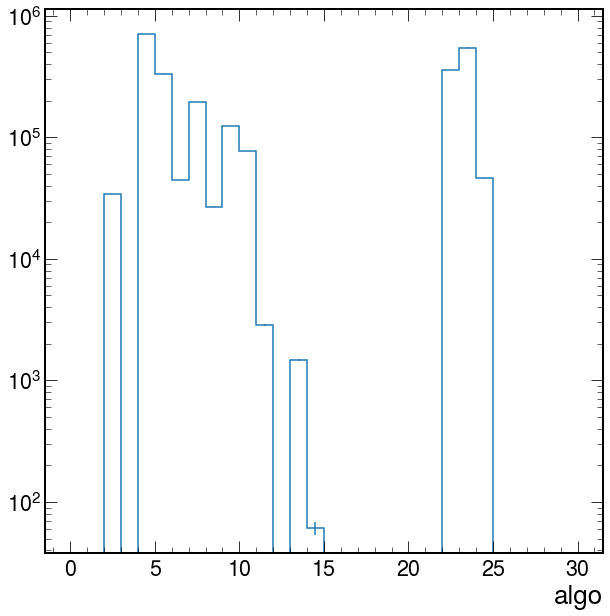

In [62]:
(
    hist.Hist.new.Regular(30, 0, 30, name="algo")
    .Double()
    .fill(ak.flatten(events.Tracks.algo))
    .plot()
)
plt.yscale('log')

In [58]:
algo_global_muons = events.Tracks[events.Tracks.algo == 19]
origAlgo_global_muons = events.Tracks[events.Tracks.origAlgo == 19]

In [59]:
ak.sum(ak.num(algo_global_muons))

0

In [60]:
ak.sum(ak.num(origAlgo_global_muons))

0